#  CNN Midi Drum Classifier

## Requirements
Have to be run in a python 3.11 env

In [51]:
#importing packages
import pretty_midi
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.pyplot as plt
%matplotlib inline
import IPython.display
import os
import subprocess

# Picking out genres from dataset

I have started using the genres rock, funk, punk, hip hop and jazz. This is because I think they all should have some distinctive qualities, and also because I think its interseting how some of them could overlap. There are for example some files who are both labeled jazz and funk. Its expected to be some overlap between genres, so I dont think aiming for 100% accuracy is possible, but seeing which genres has the most overlaps could be interessting. 

So as will be shown throughout the code, for these 5 genres, i use 803 files, being segmented into 6093 segments, everyone consisting of 2 bars, 32 timesteps using 22 drum instruments. 

In [52]:

base_dir = './data'

# Define the genres you are interested in
#10 GENRES
genres = ['latin',  'jazz',  'punk', 'afrobeat', 'hiphop', 'soul', 'funk', 'rock', 'country', 'reggae']
# 2 GENRES
# genres = ['jazz', 'rock']


# Function to check if the file genre is one of the target genres
def is_target_genre(filename):
    for genre in genres:
        if genre.replace('_', '-') in filename.lower():
            return True
    return False

# Collect all MIDI files that match the target genres
target_files = []
for root, dirs, files in os.walk(base_dir):
    for file in files:
        if file.endswith('.mid') and is_target_genre(file):
            full_path = os.path.join(root, file)
            target_files.append(full_path)

print(f"Found {len(target_files)} files in target genres.")
print(target_files[:10])

# Didnt actually end up using this, but I am keeping to code for later maybe
# Writing the paths to a text file for record-keeping or further processing
# with open('filtered_midi_files.txt', 'w') as f:
#     for item in target_files:
#         f.write("%s\n" % item)




Found 1025 files in target genres.
['./data/drummer8/session2/12_funk_81_beat_4-4.mid', './data/drummer8/session2/25_latin_84_beat_4-4.mid', './data/drummer8/session2/2_funk_92_beat_4-4.mid', './data/drummer8/session2/40_rock-indie_104_beat_4-4.mid', './data/drummer8/session2/33_rock_117_beat_4-4.mid', './data/drummer8/session2/30_afrobeat_98_beat_4-4.mid', './data/drummer8/session2/39_rock-indie_104_beat_4-4.mid', './data/drummer8/session2/14_afrobeat_103_beat_4-4.mid', './data/drummer8/session2/17_afrobeat_85_beat_4-4.mid', './data/drummer8/session2/31_afrobeat_98_beat_4-4.mid']


# Preprocsessing midi data
Processing drum tracks definetily proved to be quite difficult, and I spent far too much time trying to either use magenta or trying to take out the data myself. I ended up using Mido to extract information. This made it easy to get some data, but also limits the information available.

I get information about the time and velocity when each drum-instrument plays. 
Example:
Time: 29, Note: 55, Velocity: 127, Type: note_on

In [53]:
import mido

filepath_1 = target_files[100] 
print(filepath_1)
def process_drum_track_mido(filepath):
    # Loading the MIDI file
    mid = mido.MidiFile(filepath)
    
    for i, track in enumerate(mid.tracks):
        print(f"Track {i}: {track.name}")
        for msg in track:
            if not msg.is_meta and msg.type in ['note_on', 'note_off']:
                # Seems channel 9 i correct (dont think im missing anything here?)
                # The data set says control changes are set on channel 0, but i get no data here?
                if msg.channel == 9:
                    print(f"Time: {msg.time}, Note: {msg.note}, Velocity: {msg.velocity}, Type: {msg.type}")
                    
# Example usage
process_drum_track_mido(filepath_1)


./data/drummer1/session3/5_jazz-linear_128_beat_4-4.mid
Track 0: Midi Drums
Time: 1449, Note: 38, Velocity: 47, Type: note_on
Time: 3, Note: 38, Velocity: 64, Type: note_off
Time: 5, Note: 38, Velocity: 48, Type: note_on
Time: 0, Note: 44, Velocity: 52, Type: note_on
Time: 3, Note: 38, Velocity: 64, Type: note_off
Time: 11, Note: 38, Velocity: 54, Type: note_on
Time: 57, Note: 44, Velocity: 64, Type: note_off
Time: 47, Note: 38, Velocity: 64, Type: note_off
Time: 15, Note: 36, Velocity: 43, Type: note_on
Time: 24, Note: 36, Velocity: 41, Type: note_on
Time: 0, Note: 51, Velocity: 77, Type: note_on
Time: 0, Note: 36, Velocity: 64, Type: note_off
Time: 23, Note: 36, Velocity: 64, Type: note_off
Time: 10, Note: 51, Velocity: 64, Type: note_off
Time: 0, Note: 44, Velocity: 65, Type: note_on
Time: 21, Note: 51, Velocity: 54, Type: note_on
Time: 51, Note: 44, Velocity: 64, Type: note_off
Time: 52, Note: 51, Velocity: 64, Type: note_off
Time: 126, Note: 51, Velocity: 50, Type: note_on
Time: 1

# Extract features
Gotta make sure the CNN gets the same amount of input every time. I do this by segmenting the midi files, taking two bars at the time divided into 32 bins. In the related paper (https://arxiv.org/abs/1905.06118) each sequence has T timesteps, where T=32 corresponds to the number of sixteenth notes in 2 bars of 4/4 time, which is exactly what I'm doing by dividing each beat into 4 bins and analyzing segments of 2 bars. (I explain further the logic/math under)
They also write in the documentation of the dataset "Most of the performances are in 4/4 time, with a few examples from other time signatures.", but I have used 4/4 for all the data, which might cause some problems for a few outliers.

This is something I used the alot of time on, and can defintely contain some mistakes, but here is my logic:

Bins Represent Fixed Time Intervals: Each bin corresponds to a fixed duration of time. The number of bins per beat (bins_per_beat) determines how fine-grained this discretization is. For example, i have used that bins_per_beat is 4, so each beat is divided into 4 equal parts, or bins. This means each bin represents a quarter of a beat's duration.

Total Bins Per Segment: The total_bins_per_segment is calculated based on the bins_per_beat, the number of beats_per_bar, and the number of bars to analyze in each segment. It represents the total number of time intervals (bins) in one segment of data analyzed. If you have 2 bars, with 4 beats per bar, and you're using 4 bins per beat, then total_bins_per_segment would be 2 * 4 * 4 = 32. This means each segment is divided into 32 bins, each representing a quarter of a beat.

This creates one "dimention" of the input. There are also 22 "drum-instruments", which each gets its own 32 bins matrix related "input" creating the TxM matrix. The related paper only used 9 instruments, but I see no reason why the CNN cant handle all 22, though some instrument that is only used a few times, might just create outliers and not real classification i guess, but I have kept them all for now. But this the the table from the dataset documentation which ive followed stored in "relevant_notes".

Pitch	Roland Mapping	GM Mapping	Paper Mapping	Frequency \
36	Kick	Bass Drum 1	Bass (36)	88067  \
38	Snare (Head)	Acoustic Snare	Snare (38)	102787 \
40	Snare (Rim)	Electric Snare	Snare (38)	22262 \
37	Snare X-Stick	Side Stick	Snare (38)	9696 \
48	Tom 1	Hi-Mid Tom	High Tom (50)	13145 \
50	Tom 1 (Rim)	High Tom	High Tom (50)	1561 \
45	Tom 2	Low Tom	Low-Mid Tom (47)	3935 \
47	Tom 2 (Rim)	Low-Mid Tom	Low-Mid Tom (47)	1322 \
43	Tom 3 (Head)	High Floor Tom	High Floor Tom (43)	11260 \
58	Tom 3 (Rim)	Vibraslap	High Floor Tom (43)	1003 \
46	HH Open (Bow)	Open Hi-Hat	Open Hi-Hat (46)	3905 \
26	HH Open (Edge)	N/A	Open Hi-Hat (46)	10243 \
42	HH Closed (Bow)	Closed Hi-Hat	Closed Hi-Hat (42)	31691 \
22	HH Closed (Edge)	N/A	Closed Hi-Hat (42)	34764 \
44	HH Pedal	Pedal Hi-Hat	Closed Hi-Hat (42)	52343 \
49	Crash 1 (Bow)	Crash Cymbal 1	Crash Cymbal (49)	720 \
55	Crash 1 (Edge)	Splash Cymbal	Crash Cymbal (49)	5567 \
57	Crash 2 (Bow)	Crash Cymbal 2	Crash Cymbal (49)	1832 \
52	Crash 2 (Edge)	Chinese Cymbal	Crash Cymbal (49)	1046 \
51	Ride (Bow)	Ride Cymbal 1	Ride Cymbal (51)	43847 \
59	Ride (Edge)	Ride Cymbal 2	Ride Cymbal (51)	2220 \
53	Ride (Bell)	Ride Bell	Ride Cymbal (51)	5567 

In [54]:
import mido
import numpy as np

# This gets turned into 0,1,2,3...21 in the matrix (showed in Example Usage)
relevant_notes = [36, 38, 40, 37, 48, 50, 45, 47, 43, 58, 46, 26, 42, 22, 44, 49, 55, 57, 52, 51, 59, 53]
bins_per_beat = 4
bars = 2
beats_per_bar = 4
total_beats = bars * beats_per_bar
total_bins_per_segment = total_beats * bins_per_beat

def midi_file_to_segments(filepath, bins_per_beat=4, bars_per_segment=2):
    """
    Segment a MIDI file into multiple fixed-length segments.

    Args:
        filepath (str): Path to the MIDI file.
        bins_per_beat (int): Number of bins per beat for quantization.
        bars_per_segment (int): Number of bars to include in each segment.

    Returns:
        List of np.ndarray: A list of 2D numpy arrays, each representing a segment.
    """
    mid = mido.MidiFile(filepath)

    note_indices = {note: i for i, note in enumerate(relevant_notes)}

    segments = []
    # Calculate bins and ticks for segmentation
    beats_per_bar = 4
    total_beats_per_segment = bars_per_segment * beats_per_bar
    total_bins_per_segment = total_beats_per_segment * bins_per_beat
    ticks_per_bin = mid.ticks_per_beat // bins_per_beat

    current_segment_start_tick = 0
    segment_feature_matrix = np.zeros((len(relevant_notes), total_bins_per_segment))
    current_bin_index = 0

    for track in mid.tracks:
        current_tick = 0
        for msg in track:
            if not msg.is_meta:
                current_tick += msg.time
                while current_tick >= current_segment_start_tick + (ticks_per_bin * total_bins_per_segment):
                    # Finalize current segment and start a new one
                    segments.append(segment_feature_matrix)
                    segment_feature_matrix = np.zeros((len(relevant_notes), total_bins_per_segment))
                    current_segment_start_tick += ticks_per_bin * total_bins_per_segment
                    current_bin_index = 0

                if msg.type in ['note_on', 'note_off'] and msg.channel == 9 and msg.note in relevant_notes:
                    if current_tick >= current_segment_start_tick:
                        bin_index = (current_tick - current_segment_start_tick) // ticks_per_bin
                        if msg.type == 'note_on' and msg.velocity > 0:
                            matrix_index = note_indices[msg.note]
                            segment_feature_matrix[matrix_index, bin_index] = msg.velocity
    # Add the last segment if it contains any note-ons
    if np.any(segment_feature_matrix):
        segments.append(segment_feature_matrix)
    # print(segments[0])

    return segments


def extract_features_and_genre_from_filename(filepath):
    features = midi_file_to_segments(filepath, bins_per_beat=4, bars_per_segment=2)
    # Extract genre from the filename
    filename = os.path.basename(filepath)
    genre = None
    for g in genres:
        if g in filename.lower():
            genre = g
            break
    return features, genre





# Example Usage
For both features and how the segment data looks.

Example of one kick segment of 2 bars: 
 [  0.   0.   0.  43.   0.   0.   0.   0.   0. 111.   0.   0.   0.   0.
   0.  67.   0.   0.   0.  43.   0.   0.   0.  55.   0.   0.   0.  39.
   0.   0.   0.   0.]

So after 4 timesteps, a kick hits with an velocity of 43 and so forth.

Extracted features for 25_latin_84_beat_4-4.mid with genre latin
Extracted 20 segments from 25_latin_84_beat_4-4.mid
Example of one kick segment of 2 bars: 
 [  0.   0.   0.  58.   0.   0.   0.   0.  52.   0.   0. 118.   0.   0.
  38.  60.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0. 127.]
Example of one snare segment of 2 bars: 
 [  0. 127.   0.  16. 111.   0. 127.  86.   0.   0.   0.   0.   0. 127.
   0.  66.   0. 127.   0.  29. 127.  70. 127.   0. 127.  23. 127.  79.
   0. 127.   0.   0.]
Example of one ride bell segment of 2 bars: 
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]


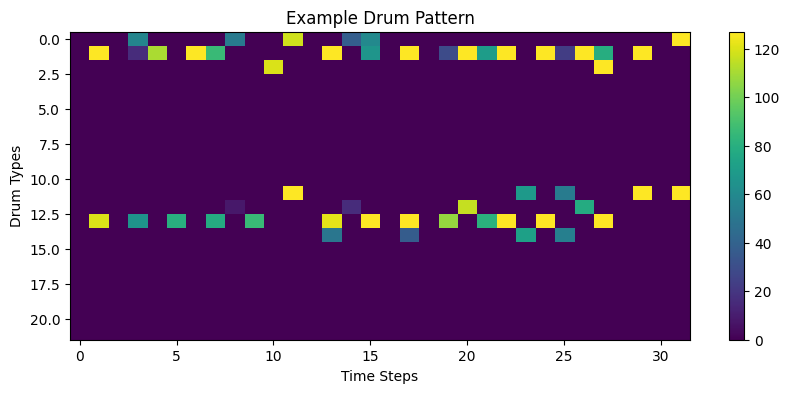

In [55]:


filepath_1 = target_files[1]
features, genre = extract_features_and_genre_from_filename(filepath_1)
print(f"Extracted features for {os.path.basename(filepath_1)} with genre {genre}")


segments = midi_file_to_segments(filepath_1)
print(f"Extracted {len(segments)} segments from {os.path.basename(filepath_1)}")
print("Example of one kick segment of 2 bars: \n",segments[1][0])
print("Example of one snare segment of 2 bars: \n",segments[1][1])
# Theres probably a lot of empty instruments like this one
print("Example of one ride bell segment of 2 bars: \n",segments[1][19])


def plot_drum_pattern(segment, title="Drum Pattern"):
    plt.figure(figsize=(10, 4))
    plt.imshow(segment, aspect='auto', cmap='viridis', interpolation='nearest')
    plt.colorbar()
    plt.title(title)
    plt.xlabel("Time Steps")
    plt.ylabel("Drum Types")
    plt.show()


if len(segments) > 0:
    plot_drum_pattern(segments[1].reshape(22, 32), title="Example Drum Pattern")


# CNN 
Using TensorFlow and Kera. 

So I was having (and still kind of am, but to a lesser degree) some problems with getting bigger gaps between accuracy of the test and validation set, hinting at overfitting. Keras has a Dropout layer which can help reduce overfitting by letting the model learn patterns instead of memorizing data (https://cnvrg.io/cnn-tensorflow/). By increasing the dropout I found good results with first 0.3 then 0.6. Other than that I have not experimented alot with variables.

In [56]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

input_shape = (len(relevant_notes), total_bins_per_segment, 1)  
num_classes = len(genres) 

def create_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.6),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model




Create Model

In [57]:

model = create_model(input_shape, num_classes)


Create train/validation dataset

In [58]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Placeholder lists for features and labels
X_list = []
y_list = []


num_classes = len(genres)

# Looping over the dataset, extracting features and labels for each segment
for filepath in target_files:
    # Instead of extracting features for the whole file, extracting for each segment
    segments = midi_file_to_segments(filepath)  # Use segmentation function
    _, genre = extract_features_and_genre_from_filename(filepath)  # Extract genre
    
    if genre is not None:
        genre_index = genres.index(genre)
        for segment in segments:
            X_list.append(segment)
            y_list.append(to_categorical(genre_index, num_classes))
    else:
        print(f"Genre label not recognized for file {filepath}. Skipping.")

# Converting lists to numpy arrays for training
X = np.array(X_list)
# Making sure that X is reshaped correctly for CNN input
X = X.reshape((-1, len(relevant_notes), total_bins_per_segment, 1))

y = np.array(y_list)

# Splitting the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)



(8601, 22, 32, 1)
(2151, 22, 32, 1)
(8601, 10)
(2151, 10)


In [59]:
history = model.fit(X_train, y_train, batch_size=128, epochs=50, validation_data=(X_val, y_val))


Epoch 1/50
68/68 [==============================] - 1s 10ms/step - loss: 4.2750 - accuracy: 0.3076 - val_loss: 1.8340 - val_accuracy: 0.3719
Epoch 2/50
68/68 [==============================] - 1s 10ms/step - loss: 1.7943 - accuracy: 0.4086 - val_loss: 1.5028 - val_accuracy: 0.5351
Epoch 3/50
68/68 [==============================] - 1s 9ms/step - loss: 1.6351 - accuracy: 0.4624 - val_loss: 1.3764 - val_accuracy: 0.5625
Epoch 4/50
68/68 [==============================] - 1s 9ms/step - loss: 1.5265 - accuracy: 0.4951 - val_loss: 1.3048 - val_accuracy: 0.5793
Epoch 5/50
68/68 [==============================] - 1s 9ms/step - loss: 1.4219 - accuracy: 0.5083 - val_loss: 1.1607 - val_accuracy: 0.5900
Epoch 6/50
68/68 [==============================] - 1s 9ms/step - loss: 1.3271 - accuracy: 0.5408 - val_loss: 1.1165 - val_accuracy: 0.6295
Epoch 7/50
68/68 [==============================] - 1s 9ms/step - loss: 1.2588 - accuracy: 0.5567 - val_loss: 1.0558 - val_accuracy: 0.6234
Epoch 8/50
68/68 [

# Analyzing
We can see that the model definetily gets better over the epochs. After a while (depending on the runs still) the Traning and validation set get bigger gaps the longer it runs indicating overfitting. This is a problem that could be improved upon. It seems like maybe +-80% is where the validation set pans out, which could make sense since there is some overlaps in the genres. 

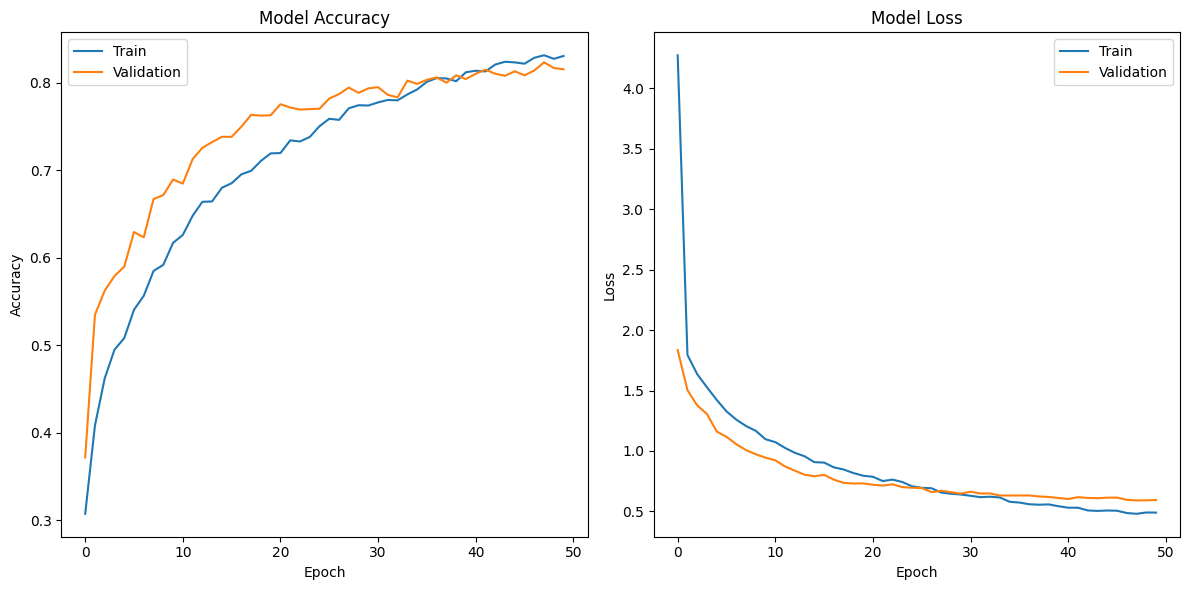

In [60]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


# Confusion Matrix
As we can see here, rock is definetely making the dataset skewed as its a lot more rock files. 

Noteably, we can see alot of overlap between hip hop and rock and funk. I assume this might be because hip hop has been influenced by sampling and therefor might not have its own indicative style. Rock is a large genre, and **can** also use quite "standard" drumming, making it overlap with many of the other genres, but jazz usualy has the best score to "hold its own", as it might have the most nuances.

68/68 [==============================] - 0s 1ms/step
Confusion matrix, without normalization
[[396  13   1   4   0   0  13  22   0   0]
 [  6 272   0   1   0   0   4  33   0   0]
 [  0   2  37   0   0   0   0   5   0   0]
 [  3   0   0  86   0   0   5   4   0   0]
 [  1   0   0   1  55   1   7  47   0   0]
 [  0   2   0   0   0  28   7  33   0   0]
 [ 13  19   0   1   1   5 211  40   2   1]
 [ 22  32   1   4   5   4  19 648   0   0]
 [  2   1   0   0   0   1   0   3   5   0]
 [  1   0   0   1   0   0   2   2   0  16]]
Normalized confusion matrix
[[0.88195991 0.02895323 0.00222717 0.00890869 0.         0.
  0.02895323 0.04899777 0.         0.        ]
 [0.01898734 0.86075949 0.         0.00316456 0.         0.
  0.01265823 0.10443038 0.         0.        ]
 [0.         0.04545455 0.84090909 0.         0.         0.
  0.         0.11363636 0.         0.        ]
 [0.03061224 0.         0.         0.87755102 0.         0.
  0.05102041 0.04081633 0.         0.        ]
 [0.00892857 0.     

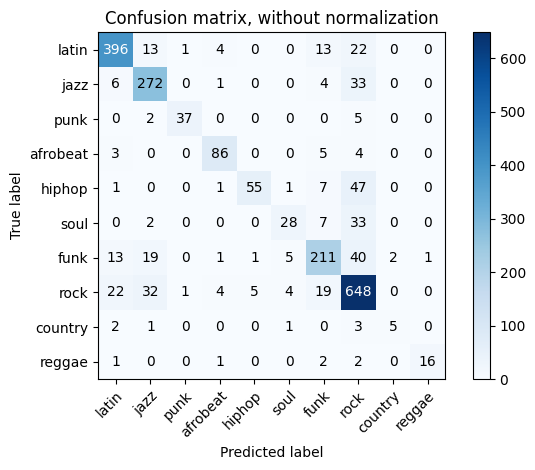

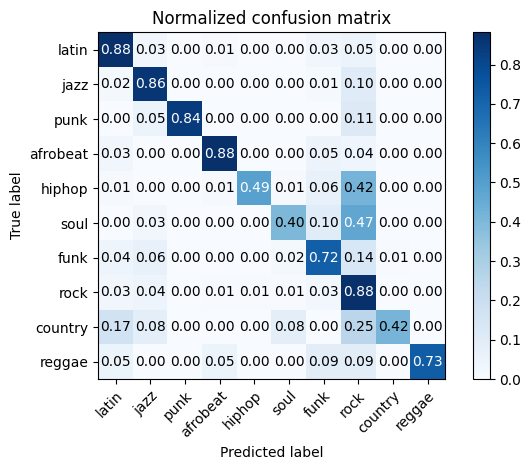

In [61]:
import sklearn

# Taken from WS2b
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    # Adjust classes based on the confusion matrix's shape
    active_classes = [classes[i] for i in np.unique(y_true)]
    
    # Set ticks and labels based on the active classes
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=active_classes, yticklabels=active_classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

# Re-run the plotting
predictions = model.predict(X_val)
predictions_indices = np.argmax(predictions, axis=1)
y_val_indices = np.argmax(y_val, axis=1)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_val_indices, predictions_indices, classes=genres,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_val_indices, predictions_indices, classes=genres, normalize=True,
                      title='Normalized confusion matrix')

plt.show()


In [62]:
from tensorflow.keras.models import Model

layer_outputs = [layer.output for layer in model.layers if 'conv' in layer.name or 'dense' in layer.name]  # Modify as necessary
feature_model = Model(inputs=model.input, outputs=layer_outputs)
features = feature_model.predict(X_train)
print(len(features))


269/269 [==============================] - 0s 1ms/step
3


In [63]:
from sklearn.model_selection import RepeatedKFold

num_splits = 10
num_repeats = 5
rkf = RepeatedKFold(n_splits=num_splits, n_repeats=num_repeats, random_state=42)

# Collecting statistics
fold_no = 1
all_scores = []

for train_index, test_index in rkf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Create a new model instance for each fold
    model = create_model(input_shape, num_classes)

    # Train model
    history = model.fit(X_train, y_train, batch_size=128, epochs=50, verbose=0)

    # Evaluate the model
    scores = model.evaluate(X_test, y_test, verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    all_scores.append(scores)
    fold_no += 1

# Calculate and print the mean and the standard deviation of the scores across folds to understand model stability
mean_scores = np.mean(all_scores, axis=0)
std_scores = np.std(all_scores, axis=0)
print(f'Mean scores across all folds: {mean_scores}')
print(f'Standard deviation across all folds: {std_scores}')

Score for fold 1: loss of 0.5859384536743164; accuracy of 82.62081742286682%
Score for fold 2: loss of 0.5127580165863037; accuracy of 83.73606204986572%
Score for fold 3: loss of 0.6370237469673157; accuracy of 79.62790727615356%
Score for fold 4: loss of 0.5645975470542908; accuracy of 81.86046481132507%
Score for fold 5: loss of 0.6084737777709961; accuracy of 82.2325587272644%
Score for fold 6: loss of 0.5668850541114807; accuracy of 82.88372159004211%
Score for fold 7: loss of 0.595907986164093; accuracy of 81.39534592628479%
Score for fold 8: loss of 0.5237739086151123; accuracy of 83.99999737739563%
Score for fold 9: loss of 0.6440483331680298; accuracy of 81.48837089538574%
Score for fold 10: loss of 0.6343451142311096; accuracy of 82.41860270500183%
Score for fold 11: loss of 0.5611114501953125; accuracy of 84.29368138313293%
Score for fold 12: loss of 0.5239000916481018; accuracy of 85.03717184066772%
Score for fold 13: loss of 0.5188086032867432; accuracy of 83.8139533996582